In [1]:
import math
from io import BytesIO
from IPython.display import Image, display
import graphviz
import cairo

### Drawing Trees in Jupyter Notebooks

These are a few experiments with drawing trees in notebooks and looking at the Reingold + Tilford algorimthm from 1981.

In [2]:
class BinaryTree:
    class Node:
        def __init__(self, key):
            self.key = key
            self.left = None
            self.right = None
        
        def __repr__(self):
            return f"Node({self.key})"

    def __init__(self):
        self.root = None

    @classmethod
    def from_list(cls, l):
        tree = cls()
        for item in l:
            tree.insert(item)
        return tree
        
    def insert(self, key):
        if self.root is None:
            self.root = self.Node(key)
        else:
            self._insert(self.root, key)

    def _insert(self, node, key):                     
            if key < node.key:
                if node.left is None:
                    node.left = self.Node(key)
                else:
                    self._insert(node.left, key)
            else:
                if node.right is None:
                    node.right = self.Node(key)
                else:
                    self._insert(node.right, key)

    def delete(self, key):
        self.root = self._delete_node(self.root, key)
        
    def _delete_node(self, node, key):
        '''
        From Knuth: note that the next greater node will always have an
        empty left child. Replace the deleted node with that node and reconnect
        right side as needed.
        '''
        if node is None:
            return None
        if key < node.key:
            node.left  = self._delete_node(node.left, key)
            return node
        elif key > node.key:
            node.right = self._delete_node(node.right, key)
            return node
        else:
            # found the node
            if node.right is None:
                return node.left
            elif node.right.left is None:
                node.right.left = node.left
                return node.right
            else:
                successor_parent = node.right
                successor = successor_parent.left
                while successor.left is not None:
                    successor_parent = successor
                    successor = successor.left
                # Splice out successor
                successor_parent.left = successor.right
                
                successor.left = node.left
                successor.right = node.right
                return successor
    
    def depth(self, node=None):
        if self.root is None:
            return 0
        
        if node is None:
            node = self.root
                
        l = 1 if node.left is None else self.depth(node.left) + 1
        r = 1 if node.right is None else self.depth(node.right) + 1
        return max(l, r)

    def size(self, node=None):
        if self.root is None:
            return 0
        
        if node is None:
            node = self.root
                
        l = 0 if node.left is None else self.size(node.left) + 1
        r = 0 if node.right is None else self.size(node.right) + 1
        return l + r
        
    def elements(self, node=None):
        if node is None:
            node = self.root
        if node.left is not None:
            yield from self.elements(node.left)

        yield node

        if node.right:
            yield from self.elements(node.right)
  

## Displaying tree with Graphviz

Out of the box, graphviz does not include a nice way to draw a binary tree. The main issue is that it makes no distinction between left and right children. When a node only has a single child (5, 10, 15 in the tree below) it's not clear whether this is a right or left child.

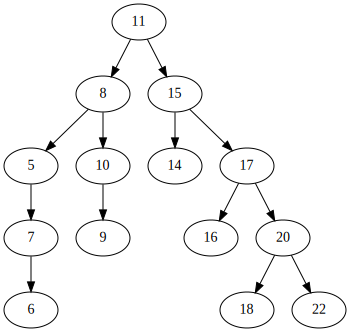

In [3]:
tree = BinaryTree.from_list([11, 8, 5, 15, 10,9, 7, 6, 17, 20, 18, 16, 22,14])

def make_graph(node, dot=None):
    if dot is None:
        dot = graphviz.Digraph('binary tree') 
    if node is None:
        return
    
    dot.node(str(node.key))

    if node.left:
        dot.edge(str(node.key), str(node.left.key))
        make_graph(node.left, dot)
    if node.right:
        dot.edge(str(node.key),  str(node.right.key))
        make_graph(node.right, dot)

    return dot 

make_graph(tree.root)

## A custom approach

Drawing our own graph with a library like pycairo is not hard, but the naive approach has a lot of shortcomings, especially with unbalnced trees. In this example the whol right subtree takes up substantially more space than needed. 

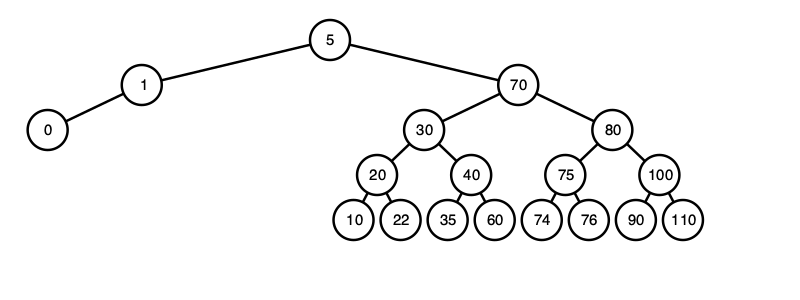

In [4]:

def disp(draw_func):
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 800, 300)
    ctx = cairo.Context(surface)
    draw_func(ctx, 800, 300)
    with BytesIO() as fileobj:
        surface.write_to_png(fileobj)
        display(Image(fileobj.getvalue(), width=800))

        
tree = BinaryTree.from_list([ 5, 70, 30, 40, 1, 60, 80, 100, 90, 20, 10,110, 75, 76, 74, 35,22, 0])
depth = tree.depth()

def draw_node(cr, node, d):
    cr.save()

    if node.right:
        cr.save()
        cr.move_to(0,0)
        cr.translate(2**d/1.7, 4.5)
        cr.line_to(0,0)
        cr.set_source_rgb(0, 0, 0) 
        cr.stroke()                 # Stroke the line
        draw_node(cr, node.right, d - 1)
        cr.restore()

    if node.left:
        cr.save()
        cr.move_to(0,0)
        cr.translate(-(2**d/1.7), 4.5)
        cr.line_to(0,0)
        cr.set_source_rgb(0, 0, 0) 
        cr.stroke()                 # Stroke the line
        draw_node(cr, node.left, d - 1)
        cr.restore()

    # draw circle
    cr.move_to(0,0)
    cr.new_sub_path() 
    cr.arc(0,0, 2,0, 2 * math.pi)
    cr.set_source_rgb(1, 1, 1)  # White fill
    cr.fill_preserve()          # Fill the circle and keep the path
    cr.set_source_rgb(0, 0, 0)  # Black for stroke
    cr.stroke()                 # Stroke the circle

    # Set text
    text = str(node.key)
    text_extents = cr.text_extents(text)
    x_offset = -text_extents.width / 2  # Center horizontally
    y_offset = text_extents.height / 2  # Center vertically (approximation)
    cr.move_to(x_offset, y_offset)
    cr.show_text(text)
    
    cr.restore()

@disp
def draw(cr, width, height):
    cr.scale(10, 10)
    w = width/2

    node = tree.root
    cr.set_line_width(.25)
    cr.set_font_size(1.5) 

    cr.translate(33, 4)
    draw_node(cr, node, depth)


# Reingold and Tilford


### Better cairo drawing

Since we will have the x,y coordinates of the nodes, just explicilty draw them.

In [5]:
class TreeDraw:
    def __init__(self, tree):
        self.tree = tree
        self.all_nodes = list(tree.elements())
        self.min_x = min(n.x for n in self.all_nodes)
        self.max_x = max(n.x for n in self.all_nodes)
        self.min_y = min(n.y for n in self.all_nodes)
        self.max_y = max(n.y for n in self.all_nodes)

        
    def draw(self, node_radius=15, scale=100, margin=50):
    
        width = int((self.max_x - self.min_x) * scale + 2 * margin) 
        height = int((self.max_y - self.min_y) * scale + 2 * margin)
    
        surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
        cr = cairo.Context(surface)
    
        cr.set_source_rgb(1, 1, 1)
        cr.paint()
    
        # This makes ugly for small trees tiny trees
        # because it scales to high, but for the trees we
        # are making, this is convenient
        cr.translate(margin - self.min_x * scale, margin - self.min_y * 100)
        cr.scale(scale, scale)
    
        cr.set_line_width(0.02)
        cr.set_source_rgb(0, 0, 0)
        self._draw_edges(cr, self.tree.root)
    
        for node in self.all_nodes:
            self._draw_node(cr, node, node_radius / 100.0)
    
        with BytesIO() as fileobj:
            surface.write_to_png(fileobj)
            display(Image(fileobj.getvalue(), width=width))
        

    def _draw_edges(self, cr, node):
        if node is None:
            return
        if node.left:
            cr.move_to(node.x, node.y)
            cr.line_to(node.left.x, node.left.y)
            cr.stroke()
        if node.right:
            cr.move_to(node.x, node.y)
            cr.line_to(node.right.x, node.right.y)
            cr.stroke()
    
        self._draw_edges(cr, node.left)
        self._draw_edges(cr, node.right)
    
    def _draw_node(self, cr, node, radius):
        # Circle
        cr.save()
        cr.new_sub_path() 
        cr.set_line_width(.05)
        cr.set_source_rgb(1, 1, 1) 
        cr.arc(node.x, node.y, radius, 0, 2 * math.pi)
        cr.fill_preserve()
        cr.set_source_rgb(0, 0, 0)
        cr.stroke()
        cr.restore()
    
        # Text (node.key)
        cr.save()
        cr.select_font_face("Sans", cairo.FONT_SLANT_NORMAL, cairo.FONT_WEIGHT_BOLD)
        cr.set_font_size(radius * 0.8)
        text = str(node.key)
        (text_x, text_y, text_w, text_h, _, _) = cr.text_extents(text)
        cr.move_to(node.x - text_w / 2, node.y + text_h / 2)
        cr.set_source_rgb(0, 0, 0)
        cr.show_text(text)
        cr.restore()


### Implementing the algorithm

[Tidier Drawings of Trees](https://reingold.co/tidier-drawings.pdf) - From https://reingold.co. march 1981

1. Add a few extra fields to our nodes to track coordinates and allow what R&T call threads that connect the outer contours of the tree when the branches are uneven.
2. Convert the original PASCAL code to something resembling Python. The original is elegant and fast.

In [6]:
MINSEP = .25

class ReingoldTree(BinaryTree):
    class Node:
        def __init__(self, key):
            self.key = key
            self.left = None
            self.right = None
            self.x = 0       
            self.y = 0       
            self.offset = 0  
            self.thread = None

        def __repr__(self):
            return f"Node({self.key})"
            

In [7]:
class Extreme:
    """
    This is in the original paper. It's a little weird to have a class
    for this, but lets follow the paper closely for now.
    """
    def __init__(self, addr=None, off=0, lev=0):
        # By default, set 'addr' to None or a Node(None)
        self.addr = addr
        self.off = off
        self.lev = lev


class ReingoldTilfordLayouter:

    def __init__(self, minsep=0.25):
        self.minsep = minsep

    def layout(self, root):
        if root is None:
            return

        rightmost = Extreme()
        leftmost = Extreme()

        self._setup(root, level=0, rmost=rightmost, lmost=leftmost)
        self._petrify(root, xpos=0)

    def _setup(self, node, level, rmost, lmost):

        if node is None:
            lmost.lev = -1
            rmost.lev = -1
            return

        node.y = level

        # Local Extreme objects for recursion LR, LL, RR, and RL in the original
        left_right_ext = Extreme() 
        left_left_ext  = Extreme() 
        right_right_ext = Extreme()
        right_left_ext  = Extreme()

        left_sub = node.left   # L and R in original
        right_sub = node.right

        self._setup(left_sub,  level+1, left_right_ext,  left_left_ext)
        self._setup(right_sub, level+1, right_right_ext, right_left_ext)

        # If leaf node, just set up trivial extremes
        if left_sub is None and right_sub is None:
            rmost.addr = node
            lmost.addr = node
            rmost.lev  = level
            lmost.lev  = level
            rmost.off  = 0
            lmost.off  = 0
            node.offset = 0
        else:
            # Not a leaf
            current_sep = self.minsep
            root_sep = self.minsep
            loffsum = 0
            roffsum = 0

            # Push subtrees apart level by level until one subtree is exhausted
            while left_sub is not None and right_sub is not None:
                if current_sep < self.minsep:
                    root_sep += self.minsep - current_sep
                    current_sep = self.minsep

                # Move left_sub one level down
                if left_sub.right is not None:
                    loffsum += left_sub.offset
                    current_sep -= left_sub.offset
                    left_sub = left_sub.right
                else:
                    loffsum -= left_sub.offset
                    current_sep += left_sub.offset
                    left_sub = left_sub.left

                # Move right_sub one level down
                if right_sub.left is not None:
                    roffsum -= right_sub.offset
                    current_sep -= right_sub.offset
                    right_sub = right_sub.left
                else:
                    roffsum += right_sub.offset
                    current_sep += right_sub.offset
                    right_sub = right_sub.right

            node.offset = (root_sep + 1) / 2
            loffsum -= node.offset
            roffsum += node.offset

            # Update extremes from child extremes
            if right_left_ext.lev > left_left_ext.lev or node.left is None:
                lmost.addr = right_left_ext.addr
                lmost.lev  = right_left_ext.lev
                lmost.off  = right_left_ext.off + node.offset
            else:
                lmost.addr = left_left_ext.addr
                lmost.lev  = left_left_ext.lev
                lmost.off  = left_left_ext.off - node.offset

            if left_right_ext.lev > right_right_ext.lev or node.right is None:
                rmost.addr = left_right_ext.addr
                rmost.lev  = left_right_ext.lev
                rmost.off  = left_right_ext.off - node.offset
            else:
                rmost.addr = right_right_ext.addr
                rmost.lev  = right_right_ext.lev
                rmost.off  = right_right_ext.off + node.offset

            # Handle threading if subtrees were uneven
            if left_sub is not None and left_sub != node.left:
                # Insert a thread in the right-right_ext node
                right_right_ext.addr.thread = True
                right_right_ext.addr.offset = abs((right_right_ext.off + node.offset) - loffsum)
                
                # Does it goe left or right?
                if loffsum - node.offset <= right_right_ext.off:
                    right_right_ext.addr.left = left_sub
                else:
                    right_right_ext.addr.right = left_sub

            elif right_sub is not None and right_sub != node.right:
                # Insert a thread in the left_left_ext node
                left_left_ext.addr.thread = True
                left_left_ext.addr.offset = abs((left_left_ext.off - node.offset) - roffsum)
                if roffsum + node.offset >= left_left_ext.off:
                    left_left_ext.addr.right = right_sub
                else:
                    left_left_ext.addr.left = right_sub

    def _petrify(self, node, xpos):
        """
        Convert offsets to x coordinates
        """
        if node is None:
            return

        node.x = xpos

        if node.thread:
            node.thread = False
            node.right = None
            node.left = None

        self._petrify(node.left,  xpos - node.offset)
        self._petrify(node.right, xpos + node.offset)

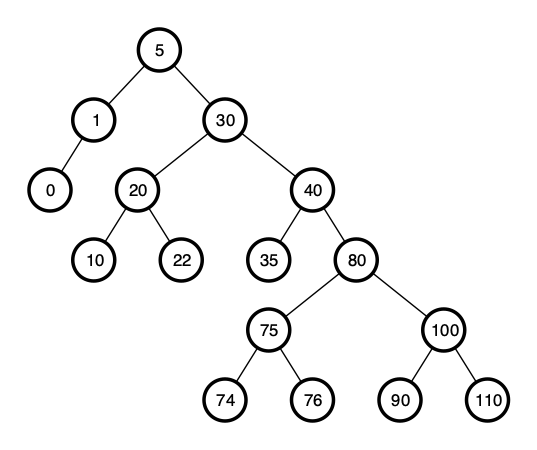

In [8]:
tree = ReingoldTree.from_list([ 5, 30, 40, 1, 80, 100, 90, 20, 10,110, 75, 76, 74, 35,22, 0])

layouter = ReingoldTilfordLayouter(minsep=0.25)
layouter.layout(tree.root)
drawer = TreeDraw(tree)
drawer.draw(node_radius=30, scale=70)

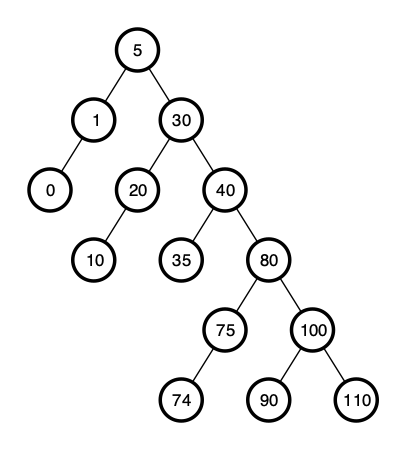

In [9]:
# It nicely handles situation where other approaches take up more room:
tree.delete(22)
tree.delete(76)

layouter = ReingoldTilfordLayouter(minsep=0.25)
layouter.layout(tree.root)

drawer = TreeDraw(tree)
drawer.draw(node_radius=30, scale=70)